# **Linear Regression Model**

In [1]:
# Set Variables
data_path = '../assets/data_filtered.csv'
time_frequencies = ['D', '3D', 'W', '3W', 'ME', '3ME']

selected_item = 'TOTAL'
selected_frequency = 'ME'

model_random_seed = 42
show_plots = True

## **Fisrt Steps**

Set init imports and variables

In [2]:
# Set imports
import pandas
import numpy
import seaborn
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [3]:
class Struct:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            if isinstance(value, dict):
                self.__dict__[key] = Struct(**value)
            else:
                self.__dict__[key] = value

In [4]:
def plotter(xy, title, y_limit, grid):
   
   dataframe = xy.copy()
   dataframe['fecha_ordinal'] = dataframe['fecha'].map(pandas.Timestamp.toordinal)
   time = numpy.asarray(dataframe['fecha'], dtype='datetime64[s]')

   coef = numpy.polyfit(dataframe['fecha_ordinal'], dataframe[selected_item], 1)
   poly1d_fn = numpy.poly1d(coef)  # Obtener la función polinómica de grado 1

   figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 3))

   ax = axes
   ax.scatter(time, dataframe[selected_item], s=12, label=selected_item)
   ax.plot(time, poly1d_fn(dataframe['fecha_ordinal']), color='purple', label='Tendencia lineal')
   ax.tick_params(axis='x', labelrotation=0)
   ax.margins(x=0.03, y=0.04)
   ax.set(
      title='  |  '.join(title),
      xlabel='Fecha', 
      ylabel='No. de Ventas',
      ylim=y_limit
   )
   ax.legend()
   if grid: 
      ax.grid()

   figure.tight_layout()

In [5]:
def standart_deviation_filter(data):
   media = data[selected_item].mean()
   desv_std = data[selected_item].std()
   rango_valido = [media - 3 * desv_std, media + 3 * desv_std]

   # Filtrar datos dentro del rango válido
   return data[(data[selected_item] >= rango_valido[0]) & (data[selected_item] <= rango_valido[1])]

In [6]:
def quantiles_filter(data):
   # Límites basados en cuartiles
   Q1 = data[selected_item].quantile(0.25)
   Q3 = data[selected_item].quantile(0.75)
   IQR = Q3 - Q1
   rango_valido = [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
   rango_valido_min = rango_valido[0]
   rango_valido_max = rango_valido[1]

   # Filtrar datos dentro del rango válido
   return data[(data[selected_item] >= rango_valido_min) & (data[selected_item] <= rango_valido_max)]

In [7]:
def linear_regression(data_x, data_y):
   model = LinearRegression()

   # Dividir los datos en conjuntos de entrenamiento y prueba
   X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=model_random_seed)

   # Crear y entrenar el modelo
   model.fit(X_train, y_train)
   
   # Realizar predicciones en el conjunto de prueba
   y_pred = model.predict(X_test)

   # Calcular el MSE y el R^2
   data_min = data_y.min()
   data_max = data_y.max()

   ecm = mean_squared_error(y_test, y_pred)
   recm = root_mean_squared_error(y_test, y_pred)
   precm = recm / (data_max - data_min) * 100

   r2 = r2_score(y_test, y_pred)
   pr2 = r2 * 100

   data_trainig = {
      'x_test': X_test,
      'x_train': X_train,
      'y_test': y_test,
      'y_train': y_train,
      'y_pred': y_pred
   }
   results = {
      'range': (data_min, data_max),

      'ecm': ecm,
      'recm': recm,
      'precm': precm,

      'r2': r2, 
      'pr2': pr2
   }

   return Struct(**{
      'model': model,
      'training': data_trainig,
      'results': results
   })

In [8]:
def frequency_grouper(data):
   data_splitted = {}
   
   for frequency in time_frequencies:
      data_metadata = {}

      frequency_data = data.groupby(pandas.Grouper(key='fecha', freq=frequency, sort=True)).sum().reset_index() if frequency != 'D' else data.copy()

      # Ennumerate data
      date_reference = frequency_data['fecha'].min()
      frequency_data['dia'] = (frequency_data['fecha'] - date_reference).dt.days + 1
      # freq_data['dia'] = freq_data['fecha'] = range(1, len(freq_data) + 1)

      # freq_data.insert(1, 'dia', (freq_data['fecha'].dt.to_period('D') + 1 - freq_data['fecha'].dt.to_period('D').min()).apply(lambda x: x.n))
      # freq_data.insert(1, 'mes', (freq_data['fecha'].dt.to_period('M') + 1 - freq_data['fecha'].dt.to_period('M').min()).apply(lambda x: x.n))
      # freq_data.insert(1, 'año', (freq_data['fecha'].dt.to_period('Y') + 1 - freq_data['fecha'].dt.to_period('Y').min()).apply(lambda x: x.n))

      data_min = frequency_data[selected_item].min()
      data_max = frequency_data[selected_item].max()
      range_diff = (data_max - data_min) / 20
      range_min = -range_diff if data_min <= 0 else 0

      data_metadata['dataset'] = frequency_data
      data_metadata['time'] = numpy.asarray(frequency_data['fecha'], dtype='datetime64[s]')
      data_metadata['range'] = (range_min, data_max + range_diff)

      data_splitted[frequency] = Struct(**data_metadata)
   
   return data_splitted

## **Prepare Data**

Groupby time frequencies and Target prediction variable (selected item)

In [9]:
# Load and prepare Dataset
datos = pandas.read_csv(data_path, parse_dates=['fecha'], date_format='%Y-%m-%d')
datos = datos[['fecha', selected_item]]
datos.head()

,fecha,TOTAL
0,2014-10-01,2
1,2014-10-02,4
2,2014-10-03,5
3,2014-10-04,6
4,2014-10-06,7


In [10]:
# Filter data by time-frequencies
data = frequency_grouper(data=datos)
independent_data = ['dia']

In [11]:
# Prepare data example to plot
data_example = data[selected_frequency]
show_plot_grids = True

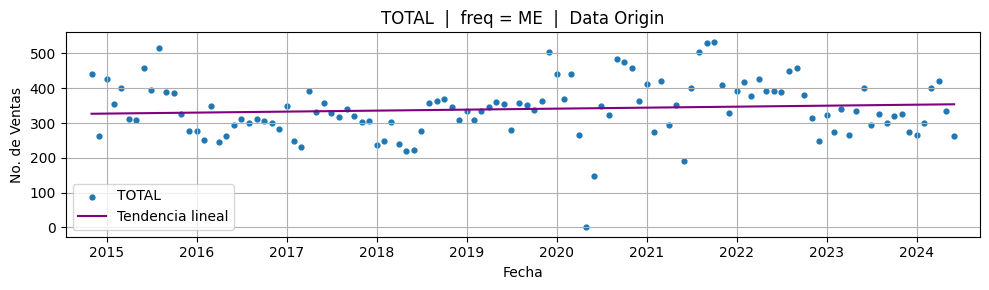

In [12]:
# Example data plot
if show_plots:
   plotter(
      xy=data_example.dataset[['fecha' ,selected_item]], 
      title=[selected_item, f'freq = {selected_frequency}', 'Data Origin'], 
      y_limit=data_example.range,
      grid=show_plot_grids,
   )

## **Out Atypical Data Filter**

Remove extreme values from data

In [13]:
# Filter data removing Out atypical (extreme) values

# Stardart deviation limits
st_dev_data = standart_deviation_filter(data=data_example.dataset)
st_dev_time = numpy.asarray(st_dev_data['fecha'], dtype='datetime64[s]')

# Quantiles limits
quant_data = quantiles_filter(data=data_example.dataset)
quant_time = numpy.asarray(quant_data['fecha'], dtype='datetime64[s]')

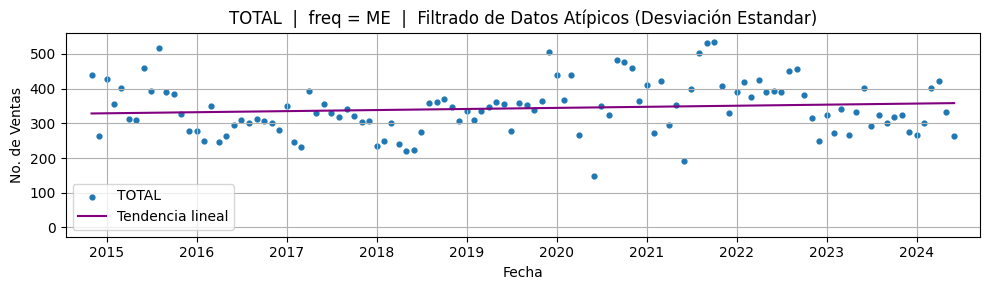

In [14]:
# Stardart Deviation plot
if show_plots:
   plotter(
      xy=st_dev_data[['fecha' ,selected_item]], 
      title=[selected_item, f'freq = {selected_frequency}', 'Filtrado de Datos Atípicos (Desviación Estandar)'], 
      y_limit=data_example.range,
      grid=show_plot_grids,
   )

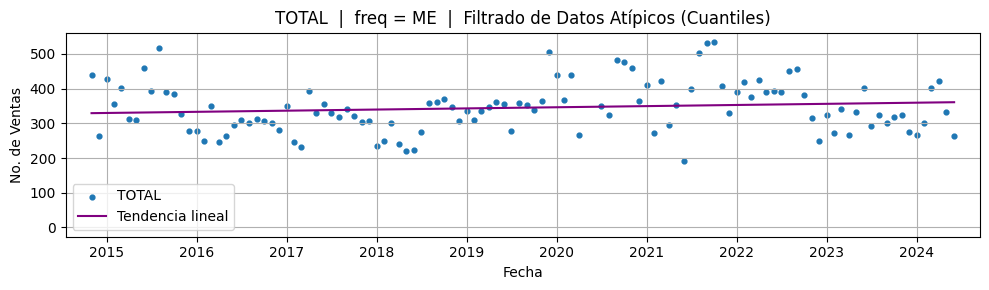

In [15]:
# Quantiles plot
if show_plots:
   plotter(
      xy=quant_data[['fecha' ,selected_item]], 
      title=[selected_item, f'freq = {selected_frequency}', 'Filtrado de Datos Atípicos (Cuantiles)'], 
      y_limit=data_example.range,
      grid=show_plot_grids,
   )

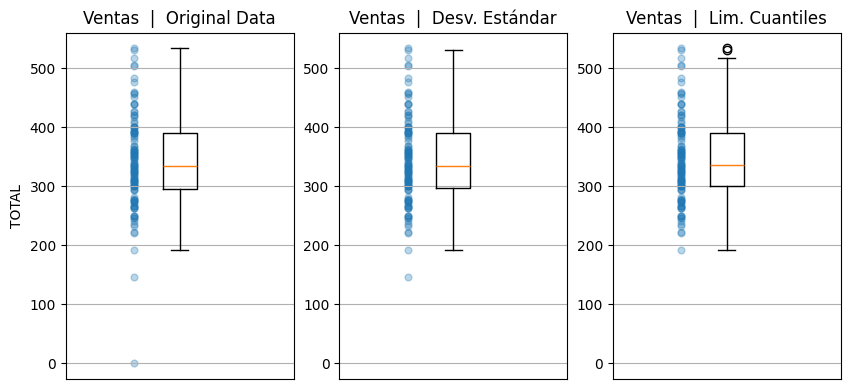

In [16]:
# Limits comparison plot
if show_plots:
   figure, axes = pyplot.subplots(ncols=3, figsize=(10, 4.5))

   ax = axes[0]
   ax.boxplot(data_example.dataset[selected_item], showfliers=False)
   ax.scatter(x=[.8] * len(data_example.dataset), y=data_example.dataset[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Original Data',
      ylabel=selected_item,
      ylim=data_example.range,
      xticks=([])
   )

   ax = axes[1]
   ax.boxplot(st_dev_data[selected_item], showfliers=False)
   ax.scatter(x=[.8] * len(st_dev_data), y=st_dev_data[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Desv. Estándar',
      ylim=data_example.range,
      xticks=([])
   )

   ax = axes[2]
   ax.boxplot(quant_data[selected_item], showfliers=True)
   ax.scatter(x=[.8] * len(quant_data), y=quant_data[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Lim. Cuantiles',
      ylim=data_example.range,
      xticks=([])
   )


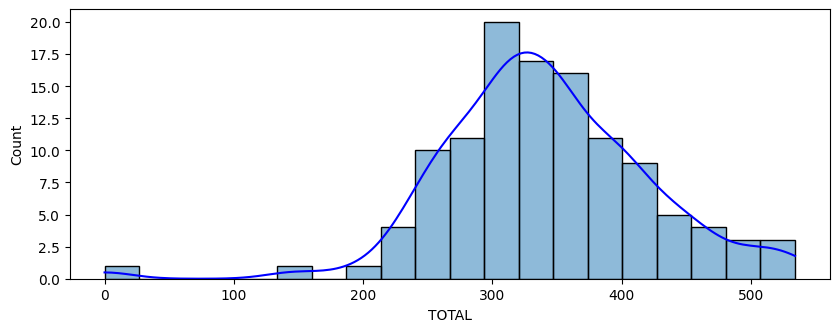

In [17]:
# Data example histogram
if show_plots:
   histogram_plot = pandas.DataFrame(data_example.dataset[selected_item])

   fig, ax = pyplot.subplots(figsize=(9.8, 3.5))

   seaborn.histplot(histogram_plot, 
      x=selected_item, 
      bins=20, 
      kde=True, 
      kde_kws = {'bw_adjust': .7}
   ).lines[0].set_color('blue')

## **Model Train and Test**

Train-Test Split data and model training

In [18]:
# Example data - Run Model
data_example = data[selected_frequency].dataset
data_example_model = linear_regression(
   data_x=data_example[independent_data], 
   data_y=data_example[selected_item]
)
data_example[['dia', selected_item]].head()

,dia,TOTAL
0,1,440
1,31,264
2,62,428
3,93,356
4,121,401


In [19]:
# Example data - Results
data_example_training = data_example_model.training
data_example_predict = data_example_training.y_pred
with numpy.nditer(data_example_predict, op_flags=['readwrite']) as it:
   for x in it:
      x[...] = f'{x:.0f}'
data_example_predict = pandas.DataFrame({ 'pred': data_example_predict }, index=list(data_example_training.y_test.index))

df_merged = pandas.concat([
   data_example_training.x_test, 
   data_example_training.y_test,
   data_example_predict
], axis=1, join='inner')
df_merged.rename(columns={selected_item: 'real'})
df_merged.head(10)


,dia,TOTAL,pred
83,2527,534,346.0
4,121,401,321.0
42,1278,220,333.0
40,1217,302,332.0
10,305,390,323.0
47,1431,369,334.0
110,3349,267,354.0
36,1097,304,331.0
70,2132,483,342.0
11,335,385,323.0


In [20]:
# Example data - Model Results
data_example_results = data_example_model.results

print(f'Item: {selected_item}')
print(f'Freq: {selected_frequency}\n')
print(f'Range: {data_example_results.range}') # Selected Item Value Ranges

# print(f'MSE: {data_example_results.ecm}') # Error Cuadrático Medio
print(f'RECM: ± {data_example_results.recm:.0f}') # Raíz del Error Cuadrático Medio
print(f'RECM(%): {data_example_results.precm:.2f} %') # Porcentaje de la Raíz del Error Cuadrático Medio

# print(f'R^2: {data_example_results.r2}') # R-Cuadrado (ajuste del modelo)
print(f'R^2(%): {data_example_results.pr2:.2f} %') # Porcentaje de R-Cuadrado

Item: TOTAL
Freq: ME

Range: (0, 534)
RECM: ± 87
RECM(%): 16.37 %
R^2(%): -3.92 %


## **Run Model**

Run multi-time-frequency model and display results

In [21]:
# Results mappers
rmse_results = {
   'Orig. Range': [],
   'Orig.': [], 
   'Stand. Dev. Range': [],
   'Stand. Dev.': [], 
   'Quant. Range': [],
   'Quant.': [],
}

prmse_results = {
   'Orig.': [],
   'Stand. Dev.': [],
   'Quant.': [],
}

pr2_results = {
   'Orig.': [],
   'Stand. Dev.': [], 
   'Quant.': [],
}

In [22]:
# Run model by freq and limit filter
for freq in time_frequencies:

   # Original data
   data_model = linear_regression(data_x=data[freq].dataset[independent_data], data_y=data[freq].dataset[selected_item])
   data_model_results = data_model.results

   rmse_results['Orig. Range'].append( f'{data_model_results.range}' )
   rmse_results['Orig.'].append( f'{data_model_results.recm:.0f}' )
   prmse_results['Orig.'].append( f'{data_model_results.precm:.1f}%' )
   pr2_results['Orig.'].append( f'{data_model_results.pr2:.0f}%' )

   # Standart deviation data
   st_dev_data = standart_deviation_filter(data=data[freq].dataset)
   st_dev_model = linear_regression(data_x=st_dev_data[independent_data], data_y=st_dev_data[selected_item])
   st_dev_model_results = st_dev_model.results

   rmse_results['Stand. Dev. Range'].append( f'{st_dev_model_results.range}' )
   rmse_results['Stand. Dev.'].append( f'{st_dev_model_results.recm:.0f}' )
   prmse_results['Stand. Dev.'].append( f'{st_dev_model_results.precm:.1f}%' )
   pr2_results['Stand. Dev.'].append( f'{st_dev_model_results.pr2:.0f}%' )

   # Quantiles data
   quant_data = standart_deviation_filter(data=data[freq].dataset)
   quant_model = linear_regression(data_x=quant_data[independent_data], data_y=quant_data[selected_item])
   quant_model_results = quant_model.results
   rmse_results['Quant. Range'].append( f'{quant_model_results.range}' )
   rmse_results['Quant.'].append( f'{quant_model_results.recm:.0f}' )
   prmse_results['Quant.'].append( f'{quant_model_results.precm:.1f}%' )
   pr2_results['Quant.'].append( f'{quant_model_results.pr2:.0f}%' )

In [23]:
# Show RMSE results
General_RMSE_Results = pandas.DataFrame(rmse_results, index=time_frequencies)
General_RMSE_Results

,Orig. Range,Orig.,Stand. Dev. Range,Stand. Dev.,Quant. Range,Quant.
D,"(-1, 124)",8,"(-1, 38)",7,"(-1, 38)",7
3D,"(0, 124)",17,"(0, 81)",16,"(0, 81)",16
W,"(0, 177)",30,"(0, 158)",29,"(0, 158)",29
3W,"(0, 390)",50,"(98, 390)",54,"(98, 390)",54
ME,"(0, 534)",87,"(147, 534)",84,"(147, 534)",84
3ME,"(264, 1473)",112,"(440, 1473)",151,"(440, 1473)",151


In [24]:
# Show RMSE (%) results
General_PRMSE_Results = pandas.DataFrame(prmse_results, index=time_frequencies)
General_PRMSE_Results

,Orig.,Stand. Dev.,Quant.
D,6.4%,17.4%,17.4%
3D,13.7%,19.6%,19.6%
W,16.9%,18.1%,18.1%
3W,12.7%,18.5%,18.5%
ME,16.4%,21.8%,21.8%
3ME,9.2%,14.6%,14.6%


In [25]:
# Show R2 results
General_R2_Results = pandas.DataFrame(pr2_results, index=time_frequencies)
General_R2_Results

,Orig.,Stand. Dev.,Quant.
D,0%,-0%,-0%
3D,-0%,-2%,-2%
W,-1%,-1%,-1%
3W,4%,-6%,-6%
ME,-4%,-10%,-10%
3ME,-29%,-21%,-21%


## **Model Predictions**

Get predictions on selected data frequency

In [26]:
# Prepare selected data
custom_frequency = 'ME'
selected_frequency = custom_frequency if custom_frequency else selected_frequency
periods_to_predict = 7

selected_data = data[selected_frequency].dataset.copy()
selected_data_range = data[selected_frequency].range

In [27]:
# Training Model
selected_lineal_regression = linear_regression(
   data_x=selected_data[independent_data], 
   data_y=selected_data[selected_item]
)
selected_data_model = selected_lineal_regression.model

In [28]:
# Show Results
selected_data_results = selected_lineal_regression.results

print(f'Item: {selected_item}')
print(f'Freq: {selected_frequency}\n')
print(f'Range: {selected_data_results.range}') # Selected Item Value Ranges

# print(f'MSE: {selected_data_results.ecm}') # Error Cuadrático Medio
print(f'RECM: ± {selected_data_results.recm:.0f}') # Raíz del Error Cuadrático Medio
print(f'RECM(%): {selected_data_results.precm:.2f} %') # Porcentaje de la Raíz del Error Cuadrático Medio

# print(f'R^2: {selected_data_results.r2}') # R-Cuadrado (ajuste del modelo)
print(f'R^2(%): {selected_data_results.pr2:.2f} %') # Porcentaje de R-Cuadrado

Item: TOTAL
Freq: ME

Range: (0, 534)
RECM: ± 87
RECM(%): 16.37 %
R^2(%): -3.92 %


In [29]:
# Set future dates to predict
date_references = [selected_data['fecha'].min(), selected_data['fecha'].max()]

future_dates = pandas.date_range(date_references[1], periods=periods_to_predict+1, freq=selected_frequency)
data_future_dates = pandas.DataFrame({'fecha': future_dates})
data_future_dates['dia'] = (data_future_dates['fecha'] - date_references[0]).dt.days + 1

data_predictions = data_future_dates.iloc[1:].reset_index()[['fecha', 'dia']]
# data_predictions

In [30]:
# Prediction Results
predictions = list( selected_data_model.predict(data_predictions[['dia']]) )
# predictions = list(map(int, predictions))
predictions = [round(x) for x in predictions]

data_predictions[selected_item] = pandas.DataFrame({ selected_item: predictions })
data_predictions

,fecha,dia,TOTAL
0,2024-06-30,3531,356
1,2024-07-31,3562,356
2,2024-08-31,3593,357
3,2024-09-30,3623,357
4,2024-10-31,3654,357
5,2024-11-30,3684,357
6,2024-12-31,3715,358


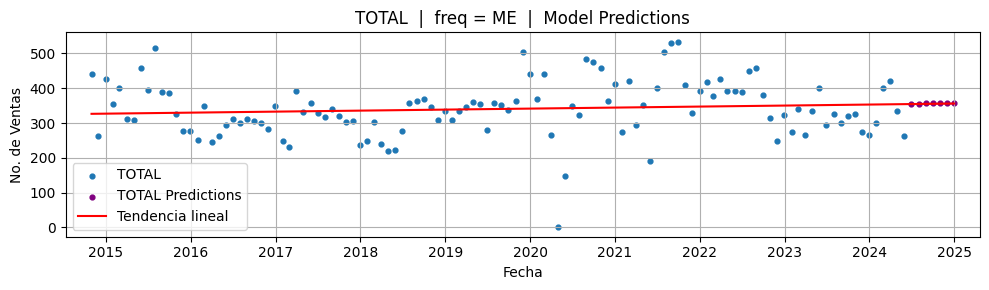

In [31]:
# Plot Results

# Concat data and predictions
concat = pandas.concat([ selected_data, data_predictions ])[['fecha', 'dia', selected_item]]
concat['fecha_ordinal'] = concat['fecha'].map(pandas.Timestamp.toordinal)
time = numpy.asarray(concat['fecha'], dtype='datetime64[s]')

coeficiet = numpy.polyfit(concat['fecha_ordinal'], concat[selected_item], 1)
poly1d_fn = numpy.poly1d(coeficiet)

# Plot concated data
figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 3))

ax = axes
ax.scatter(time[:-periods_to_predict], selected_data[selected_item], s=12, label=selected_item)
ax.scatter(time[-periods_to_predict:], data_predictions[selected_item], s=12, label=f'{selected_item} Predictions', color='purple')
ax.plot(time, poly1d_fn(concat['fecha_ordinal']), color='red', label='Tendencia lineal')
ax.tick_params(axis='x', labelrotation=0)
ax.margins(x=0.03, y=0.04)
ax.set(
   title='  |  '.join([selected_item, f'freq = {selected_frequency}' ,'Model Predictions']),
   xlabel='Fecha', 
   ylabel='No. de Ventas',
   ylim=selected_data_range
)
ax.legend()
ax.grid()

figure.tight_layout()